# Importar historico de preços de ativos B3

## Imports

In [1]:
import MetaTrader5 as mt5
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model      import LinearRegression
from statsmodels.tsa.stattools import adfuller
#import quiz_tests

In [2]:
# Initializing MT5 connection 
#if not mt5.initialize(path="D:\\programs\\metatrader\\modal\\terminal64.exe"): # producao modal
#if not mt5.initialize(path="D:\\programs\\metatrader\\desen\\terminal64.exe", portable=True): # desen modal
if not mt5.initialize(path="D:\\programs\\metatrader\\modal\\terminal64.exe", portable=True): # produ modal
    print("initialize() failed, error code =",mt5.last_error())
    quit()
    
print("MetaTrader5 terminal_info():", mt5.terminal_info())
print("MetaTrader5 version()      :", mt5.version()      )

MetaTrader5 terminal_info(): TerminalInfo(community_account=True, community_connection=True, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=True, build=3320, maxbars=50000, codepage=1252, ping_last=18070, community_balance=9.995246, retransmission=0.7644505819688302, company='Modal DTVM Ltda.', name='ModalMais MetaTrader 5', language='Portuguese (Brazil)', path='D:\\programs\\metatrader\\modal', data_path='D:\\programs\\metatrader\\modal', commondata_path='C:\\Users\\marco\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
MetaTrader5 version()      : (500, 3320, '03 Jun 2022')


In [3]:
#obtendo os dados do símbolos na corretora...
import re
def get_symbol_info():
    # obtemos todos os símbolos
    symbols=mt5.symbols_get()
    qtd_symb = len(symbols)
    count=0

    vals = []
    cols = []
    for s in symbols:
        count+=1
        #if count > 3: break
        #print("Importando {} {}/{}".format(s.name, count, qtd_symb))

        # exibimos as propriedades do símbolo como uma lista
        symbol_info_dict = s._asdict()
        if count==1: 
            cols = symbol_info_dict.keys()
            print(cols)
        vals.append(symbol_info_dict.values() )
    
    # criando coluna extra com a categoria...
    dfs = pd.DataFrame(data=vals,columns=cols)
    dfs["categ"] = dfs["path"].str.split("\\").str.get(0)
    
    # eliminando a coluna com path...
    dfs.drop(["path","page","session_volume","session_interest"], axis=1, inplace=True)
    
    for col in dfs.columns:
        if dfs[col].max() == dfs[col].min():
            print("Elimanado a coluna ", col, " tipo:", dfs[col].dtype, " max:", dfs[col].max(), " min:", dfs[col].min())
            dfs.drop([col], axis=1, inplace=True)
    
    #for col in dfs.columns:
    #    print(dfs[col].dtype)
    
    return dfs


In [4]:
# obtendo os dados de simbolos na corretora...
dfs = get_symbol_info()
dfs.head()

# salvamos as propriedades dos simbolos em uma planilha
dfs.to_excel("symbols_b3.xlsx")
#dfs = pd.read_excel("symbols_b3.xlsx")

dict_keys(['custom', 'chart_mode', 'select', 'visible', 'session_deals', 'session_buy_orders', 'session_sell_orders', 'volume', 'volumehigh', 'volumelow', 'time', 'digits', 'spread', 'spread_float', 'ticks_bookdepth', 'trade_calc_mode', 'trade_mode', 'start_time', 'expiration_time', 'trade_stops_level', 'trade_freeze_level', 'trade_exemode', 'swap_mode', 'swap_rollover3days', 'margin_hedged_use_leg', 'expiration_mode', 'filling_mode', 'order_mode', 'order_gtc_mode', 'option_mode', 'option_right', 'bid', 'bidhigh', 'bidlow', 'ask', 'askhigh', 'asklow', 'last', 'lasthigh', 'lastlow', 'volume_real', 'volumehigh_real', 'volumelow_real', 'option_strike', 'point', 'trade_tick_value', 'trade_tick_value_profit', 'trade_tick_value_loss', 'trade_tick_size', 'trade_contract_size', 'trade_accrued_interest', 'trade_face_value', 'trade_liquidity_rate', 'volume_min', 'volume_max', 'volume_step', 'volume_limit', 'swap_long', 'swap_short', 'margin_initial', 'margin_maintenance', 'session_volume', 'sess

In [5]:
# obtendo os filtros em uma planilha da B3 com os simbolos cujo volume de trades no dia eh maior que 10mil.
#dffilter = pd.read_excel("TradeInformationConsolidatedFile.xlsx")
#dffilter = pd.read_csv("TradeInformationConsolidatedFile.csv",sep=";")

# simbolos que serao efetivamente processados
#dffilter = pd.read_excel("filtro.xlsx",sep=";") #filtro.xls contem os simbolos que queremos importar
#dfs = dfs[ dfs["name"].isin(dffilter["ticker"]) ] 

# simbolos que serao efetivamente processados
dffilter = pd.read_excel("filtro-20220709-acoes.xlsx") #filtro.xls contem os simbolos que queremos importar
dfs = dfs[ dfs["name"].isin(dffilter["TckrSymb"]) ] 

dfs

,select,visible,session_deals,volume,volumehigh,volumelow,time,digits,spread,ticks_bookdepth,...,price_change,price_theoretical,basis,currency_base,currency_profit,currency_margin,description,isin,name,categ
17,True,True,11697,100,787100,100,1659355835,2,1,16,...,-1.3396,14.86,,BRL,BRL,BRL,AMBEV S/A ON,BRABEVACNOR1,ABEV3,BVMF-Equities
208,True,True,4846,100,8600,100,1659355834,2,2,16,...,-1.6371,21.98,,BRL,BRL,BRL,ALPARGATAS PN N1,BRALPAACNPR7,ALPA4,BVMF-Equities
285,True,True,2197,100,7400,100,1659355820,2,1,16,...,2.6786,4.45,,BRL,BRL,BRL,ANIMA ON NM,BRANIMACNOR6,ANIM3,BVMF-Equities
402,True,True,5494,1100,37800,100,1659355824,2,1,16,...,1.7903,11.61,,BRL,BRL,BRL,AZUL PN N2,BRAZULACNPR4,AZUL4,BVMF-Equities
415,True,True,9148,100,70000,100,1659355834,2,1,16,...,-0.2705,11.02,,BRL,BRL,BRL,B3 ON NM,BRB3SAACNOR6,B3SA3,BVMF-Equities
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31211,True,True,2989,100,10000,100,1659355821,2,1,16,...,-0.3077,9.70,,BRL,BRL,BRL,DEXCO ON NM,BRDXCOACNOR8,DXCO3,BVMF-Equities
32118,True,True,6710,4,3100,1,1659355833,2,7,16,...,2.8637,107.40,,BRL,BRL,BRL,XP INC DR1,BRXPBRBDR001,XPBR31,BVMF-Equities
32527,True,True,6717,500,9500,100,1659355834,2,1,16,...,0.9610,16.73,,BRL,BRL,BRL,VIBRA ON NM,BRVBBRACNOR1,VBBR3,BVMF-Equities
33111,True,True,4177,100,4900,100,1659355829,2,1,16,...,2.0749,19.66,,BRL,BRL,BRL,IGUATEMI S.AUNT N1,BRIGTICDAM16,IGTI11,BVMF-Equities


In [6]:
def get_simbols_com_volume_ateh(planilha_TradeInformationConsolidatedFile, TradQty, SgmtNm):
    """
    Leh a planilha de informacoes consolidadas da B3 em formato csv, 
    filtra segundo a quantidade de trades no dia e o nome do segmento
    retorna um Dataframe com o simbolo na coluna TckrSymb
    
    Parameters
    ----------
    planilha_TradeInformationConsolidatedFile : string
        Nome da planilha B3 com a informacao de negociacoes consolidadas
    TradQty : int
        [filtro] Quantidade minima de negociacoes no dia.
    SgmtNm : string
        [filtro] Nome do segmento cujos ativos queremos selecionar
    
    Returns
    -------
    df_symbols : DataFrame
        Dataframe com os simbolos selecionados
    """
    df_symbols = pd.read_csv(planilha_TradeInformationConsolidatedFile, sep=";",decimal=",",thousands=".")
    return df_symbols

In [19]:
df = get_simbols_com_volume_ateh("TradeInformationConsolidatedFile_20220706_1.csv", 10000, "CASH")
#df
df_mask=df[' TradQty ']>10000 and 
df = df[df_mask]
df

,RptDt,TckrSymb,ISIN,SgmtNm,MinPric,MaxPric,TradAvrgPric,LastPric,AdjstdQt,AdjstdQtTax,RefPric,TradQty,FinInstrmQty
0,06/07/2022,WINQ22,BRBMEFWIN2Z1,FINANCIAL,98625.00,100440.00,99482.000,99955.00,99995.000,NaN,NaN,5901920.0,18435911.0
1,06/07/2022,WDOQ22,BRBMEFWDO3V2,FINANCIAL,5431.00,5500.00,5462.484,5463.50,5456.829,NaN,NaN,1243008.0,3593117.0
2,06/07/2022,PETR4,BRPETRACNPR6,CASH,26.91,28.48,27.550,27.67,NaN,NaN,NaN,81786.0,57617200.0
3,06/07/2022,BOVA11,BRBOVACTF003,CASH,93.97,95.66,95.060,95.42,NaN,NaN,NaN,62416.0,6784584.0
4,06/07/2022,VALE3,BRVALEACNOR0,CASH,73.54,75.45,74.580,75.00,NaN,NaN,NaN,61161.0,23138800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,06/07/2022,CRFB3,BRCRFBACNOR2,CASH,16.58,17.19,16.870,16.84,NaN,NaN,NaN,10408.0,4727500.0
104,06/07/2022,BRAP4,BRBRAPACNPR2,CASH,24.27,25.07,24.680,24.83,NaN,NaN,NaN,10347.0,3005900.0
105,06/07/2022,QUAL3,BRQUALACNOR6,CASH,11.79,12.50,12.170,12.28,NaN,NaN,NaN,10118.0,2485400.0
106,06/07/2022,RADL3,BRRADLACNOR0,CASH,18.87,19.61,19.310,19.50,NaN,NaN,NaN,10087.0,4534500.0


In [18]:
#df.columns
df[' TradQty ']

0        5901920.0
1        1243008.0
2          81786.0
3          62416.0
4          61161.0
           ...    
40379          NaN
40380          NaN
40381          NaN
40382          NaN
40383          NaN
Name:  TradQty , Length: 40384, dtype: float64

In [7]:
# retornamos um dataframe com os preços do ativo desde a data informada... 
def get_ticker_data(symbol,ano,mes,dia,qtd,timeframe=mt5.TIMEFRAME_D1):
    symbol_info=mt5.symbol_info(symbol)
    if symbol_info!=None:
        
        # importamos o módulo pytz para trabalhar com o fuso horário
        import pytz        # definimos o fuso horário como UTC
        timezone = pytz.timezone("Etc/UTC")

        dt = datetime(ano, mes, dia, tzinfo=timezone)
        # recebemos qtd barras de symbol a partir de dt no fuso horário UTC. As barras contam desde dt pra tras
        rates = mt5.copy_rates_from(symbol, timeframe, dt, qtd)
        # a partir dos dados recebidos criamos o DataFrame
        rates_frame = pd.DataFrame(rates)
        # convertemos o tempo em segundos para o formato datetime
        rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
        #rates_frame.set_index("time")

        rates_frame["ticker"]=symbol

        return rates_frame



In [8]:
# retornando um dataframe com os precos dos ativos informados em symbols
def get_all_ticker_data(symbols,ano,mes,dia,qtd,timeframe=mt5.TIMEFRAME_D1, verbose=False):
    """
    A partir da data informada, busca ´qtd´ barras do timeframe informado pra tras.
    """
    i=0
    processados=0
    tot_symbols = len(symbols)
    
    for symb in symbols:
        if verbose:
            print("Obtendo", symb, i+1, "de", tot_symbols, "...")

        dfs2 = get_ticker_data(symb,ano,mes,dia,qtd,timeframe)
        #print(dfs2)

        #if( dfs2 != None ):
        if i>0:
            #dfall = dfall.append(dfs2)
            dfall = pd.concat([dfall,dfs2])
        else: 
            dfall = dfs2
        i = i+1
    
    return dfall


In [9]:
dfa = get_all_ticker_data(dfs["name"], 2022,7,14,1000, timeframe=mt5.TIMEFRAME_H1,verbose=True)
dfa


Obtendo ABEV3 1 de 98 ...
Obtendo ALPA4 2 de 98 ...
Obtendo ANIM3 3 de 98 ...
Obtendo AZUL4 4 de 98 ...
Obtendo B3SA3 5 de 98 ...
Obtendo BBAS3 6 de 98 ...
Obtendo BBDC4 7 de 98 ...
Obtendo BBSE3 8 de 98 ...
Obtendo BEEF3 9 de 98 ...
Obtendo BOVA11 10 de 98 ...
Obtendo BOVV11 11 de 98 ...
Obtendo BPAC11 12 de 98 ...
Obtendo BRAP4 13 de 98 ...
Obtendo BRFS3 14 de 98 ...
Obtendo BRKM5 15 de 98 ...
Obtendo BRML3 16 de 98 ...
Obtendo CCRO3 17 de 98 ...
Obtendo CIEL3 18 de 98 ...
Obtendo CMIG4 19 de 98 ...
Obtendo CPFE3 20 de 98 ...
Obtendo CPLE6 21 de 98 ...
Obtendo CRFB3 22 de 98 ...
Obtendo CSAN3 23 de 98 ...
Obtendo CSNA3 24 de 98 ...
Obtendo CVCB3 25 de 98 ...
Obtendo CYRE3 26 de 98 ...
Obtendo ECOR3 27 de 98 ...
Obtendo ELET3 28 de 98 ...
Obtendo ELET6 29 de 98 ...
Obtendo EMBR3 30 de 98 ...
Obtendo ENBR3 31 de 98 ...
Obtendo ENEV3 32 de 98 ...
Obtendo ENGI11 33 de 98 ...
Obtendo EQTL3 34 de 98 ...
Obtendo GGBR4 35 de 98 ...
Obtendo GOAU4 36 de 98 ...
Obtendo GOLL4 37 de 98 ...
Obtend

,time,open,high,low,close,tick_volume,spread,real_volume,ticker
0,2022-01-17 17:00:00,14.81,14.83,14.80,14.82,3683,1,1567800,ABEV3
1,2022-01-17 18:00:00,14.80,14.80,14.80,14.80,148,0,1776400,ABEV3
2,2022-01-18 10:00:00,14.74,14.74,14.43,14.48,4079,0,2812100,ABEV3
3,2022-01-18 11:00:00,14.48,14.52,14.39,14.41,8039,1,5236700,ABEV3
4,2022-01-18 12:00:00,14.41,14.54,14.41,14.50,4918,1,3058700,ABEV3
...,...,...,...,...,...,...,...,...,...
995,2022-07-11 12:00:00,3.28,3.33,3.27,3.29,1964,1,604326,NUBR33
996,2022-07-11 13:00:00,3.29,3.30,3.23,3.26,2634,1,814816,NUBR33
997,2022-07-11 14:00:00,3.26,3.30,3.25,3.29,2392,1,521488,NUBR33
998,2022-07-11 15:00:00,3.29,3.30,3.25,3.25,3011,0,786475,NUBR33


In [10]:
#dfa.to_csv("dfa_h1_b3.csv")
dfa.to_excel("dfa_h1_b3.xlsx")


In [11]:
#dfo = dfa.pivot(index='time', columns='ticker', values='open')
dfc = dfa.pivot(index='time', columns='ticker', values='close').dropna()
dfv = dfa.pivot(index='time', columns='ticker', values='real_volume').dropna()

dfc.to_excel("dfc.xlsx")
dfc


ticker,ABEV3,AERI3,ALPA4,ALSO3,AMBP3,AMER3,ANIM3,ASAI3,AZUL4,B3SA3,...,TAEE11,TOTS3,USIM5,VALE3,VAMO3,VBBR3,VIIA3,WEGE3,XPBR31,YDUQ3
time,,,,,,,,,,,,,,,,,,,,,
2022-01-18 18:00:00,14.58,5.93,28.54,19.35,33.94,30.21,6.83,11.92,25.61,12.31,...,34.32,24.17,16.54,83.11,9.74,19.60,3.75,30.54,151.59,19.63
2022-01-19 10:00:00,14.60,5.95,28.42,19.92,34.12,32.40,6.97,12.15,26.12,12.44,...,34.46,25.00,16.85,85.07,9.84,19.86,3.94,30.98,152.94,19.99
2022-01-19 11:00:00,14.47,5.96,28.70,20.10,34.43,32.67,7.06,12.13,25.97,12.36,...,34.66,25.32,17.07,85.43,9.96,20.22,3.98,30.80,153.38,19.71
2022-01-19 12:00:00,14.52,6.01,28.71,19.90,34.41,33.17,6.97,12.17,25.79,12.38,...,34.86,25.34,16.98,84.88,9.99,20.37,4.07,30.71,155.00,19.89
2022-01-19 13:00:00,14.44,6.02,28.70,20.09,34.19,33.68,6.95,12.12,25.73,12.39,...,34.89,25.34,16.85,85.03,10.03,20.52,4.08,30.58,158.36,19.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-11 12:00:00,14.08,2.71,20.05,16.49,24.17,15.79,4.42,15.35,11.71,10.90,...,39.29,24.04,8.55,73.12,11.04,16.34,2.37,26.58,93.00,14.69
2022-07-11 13:00:00,14.16,2.65,20.13,16.40,23.91,15.80,4.39,15.33,11.67,10.88,...,39.22,24.12,8.39,72.86,10.92,16.37,2.37,26.53,92.97,14.57
2022-07-11 14:00:00,14.11,2.59,20.01,16.35,23.76,15.75,4.38,15.36,11.62,10.87,...,39.21,24.14,8.44,72.89,10.83,16.29,2.37,26.48,93.66,14.48


<AxesSubplot:xlabel='time'>

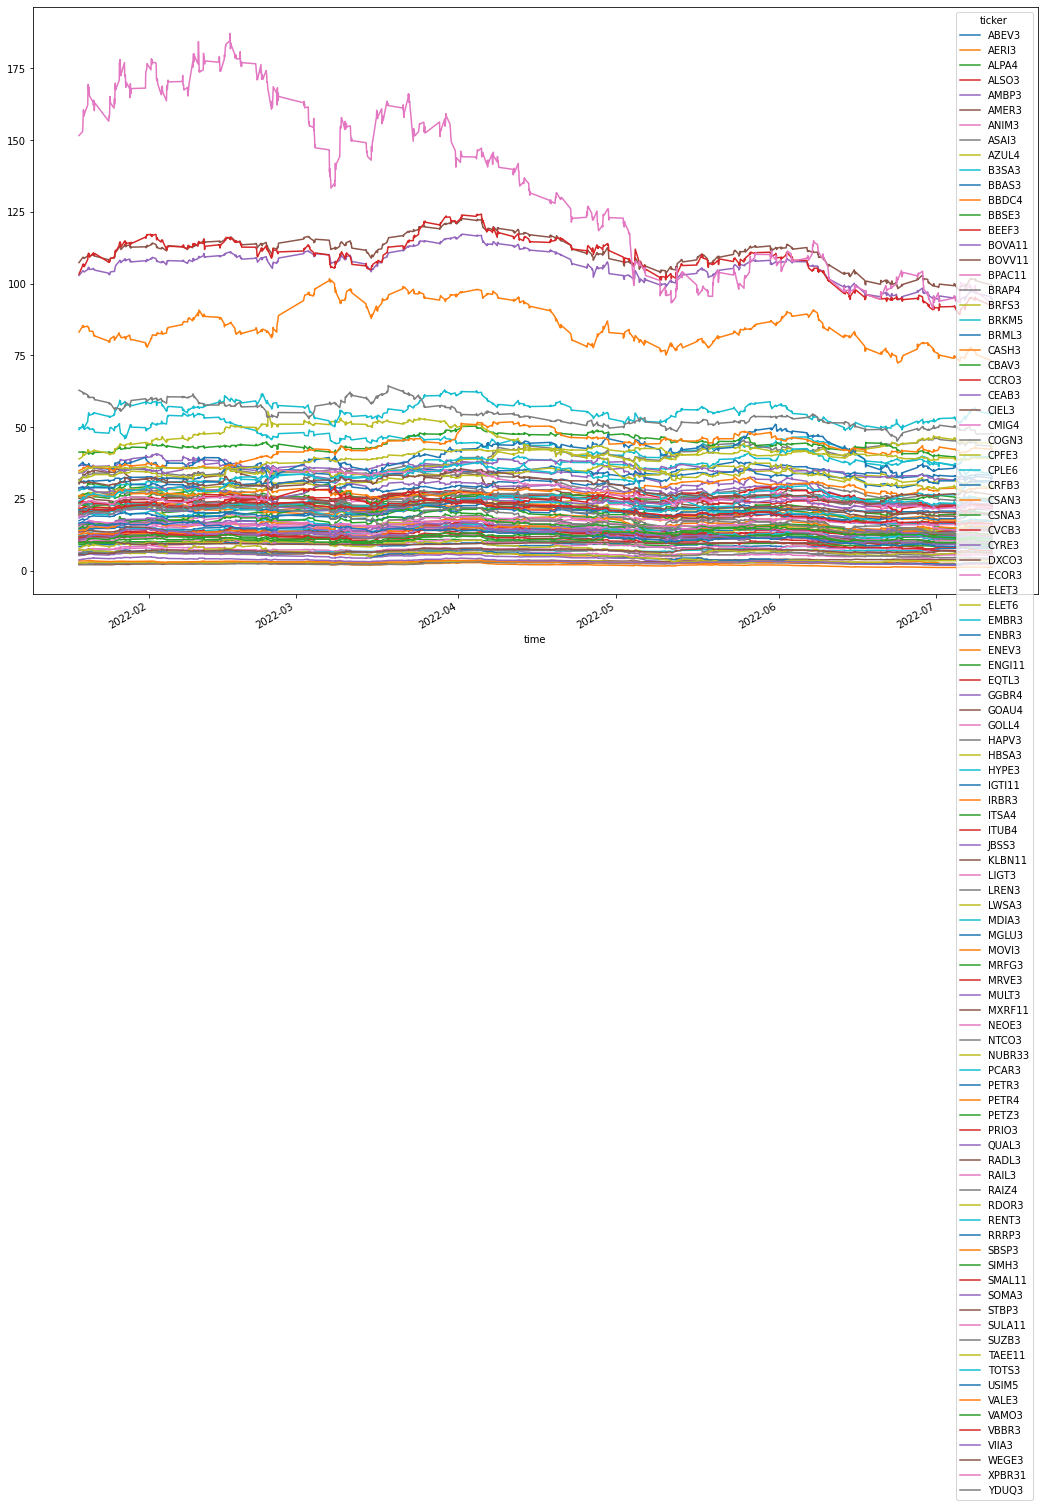

In [12]:
dfc.plot(figsize=(18,12))

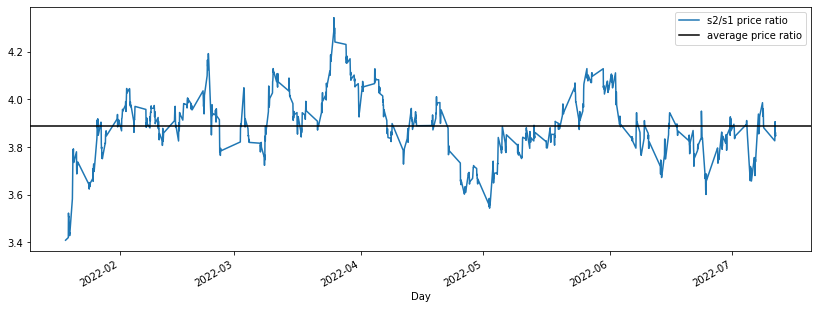

average price ratio 3.8867


In [13]:
s1 = dfc.ABEV3 # dfc.BOVA11
s2 = dfc.RENT3 # dfc.WINQ22
price_ratio = s2/s1
price_ratio.plot(figsize=(14,5)) 
plt.axhline(price_ratio.mean(), color='black') 
plt.xlabel('Day')
plt.legend(['s2/s1 price ratio', 'average price ratio'])
plt.show()
print(f"average price ratio {price_ratio.mean():.4f}")

## Calculate hedge ratio with regression

## Linear Regression

Note that the LinearRegression().fit() expects 2D numpy arrays.  Since s1 and s2 are pandas series, we can use Series.values to get the values as a numpy array. Since these are 1D arrays, we can use numpy.reshape(-1,1) to make these 1000 row by 1 column 2 dimensional arrays


Observe que LinearRegression().fit() espera matrizes numpy 2D. Como s1 e s2 são séries pandas, podemos usar Series.values para obter os valores como uma matriz numpy. Como esses são arrays 1D, podemos usar numpy.reshape (-1,1) para tornar esses arrays bidimensionais de 1000 linhas por 1 coluna.

In [140]:
s1.values.reshape(-1,1).shape

(986, 1)

In [14]:
lr = LinearRegression()
lr.fit(s1.values.reshape(-1,1),s2.values.reshape(-1,1))

LinearRegression()

In [15]:
hedge_ratio = lr.coef_[0][0]
hedge_ratio

4.007391202926802

In [16]:
intercept = lr.intercept_[0]
intercept

-1.7237711516578216

In [17]:
print(f"hedge ratio from regression is {hedge_ratio:.4f}, intercept is {intercept:.4f}")

hedge ratio from regression is 4.0074, intercept is -1.7238


 ## Question
 Do you think we'll need the intercept when calculating the spread?  Why or why not?
 
 Você acha que precisaremos da interceptação ao calcular o spread? Por que ou por que não?

## Calculate the spread

In [18]:
spread = s2 - s1 * hedge_ratio

In [19]:
print(f"Average spread is {spread.mean()}")

Average spread is -1.7237711516578236


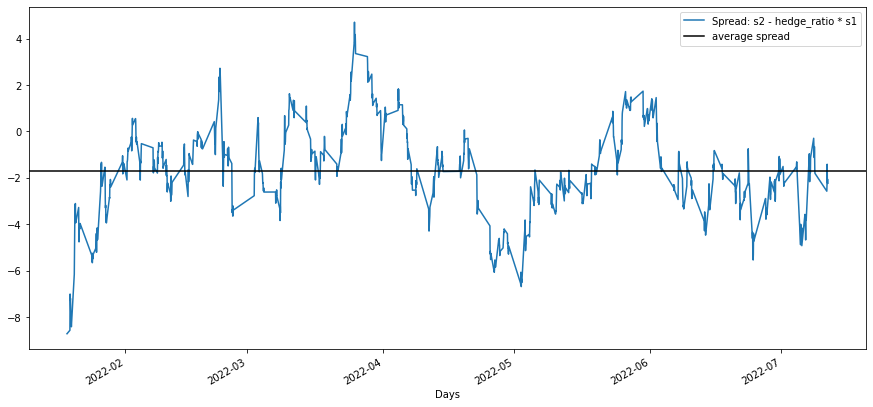

In [20]:
spread.plot(figsize=(15,7)) 
plt.axhline(spread.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['Spread: s2 - hedge_ratio * s1', 'average spread'])
plt.show()

In [149]:
print(spread)

time
2022-01-17 17:00:00   -7.952376
2022-01-17 18:00:00   -8.023317
2022-01-18 10:00:00   -7.908381
2022-01-18 11:00:00   -8.501676
2022-01-18 12:00:00   -8.557439
                         ...   
2022-07-08 17:00:00   -1.024500
2022-07-11 10:00:00   -1.799208
2022-07-11 11:00:00   -1.542973
2022-07-11 12:00:00   -0.647210
2022-07-11 13:00:00   -1.443444
Length: 986, dtype: float64


## Let's see what we get if we include the intercept of the regression

Vamos ver o que temos se incluirmos o intercepto da regressão

In [21]:
spread_with_intercept = s2 - (s1 * hedge_ratio + intercept)
print(f"Average spread with intercept included is {spread_with_intercept.mean()}")

Average spread with intercept included is -1.9741330350025254e-15


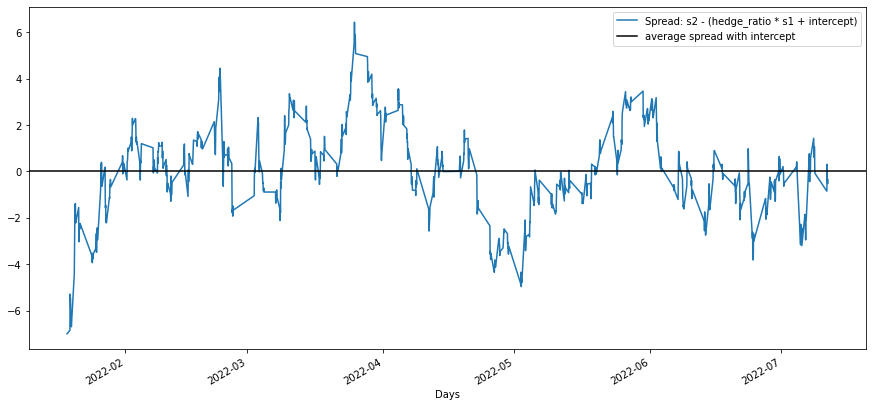

In [22]:
spread_with_intercept.plot(figsize=(15,7)) 
plt.axhline(spread_with_intercept.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['Spread: s2 - (hedge_ratio * s1 + intercept)', 'average spread with intercept'])
plt.show()

## Quiz
### Check if spread is stationary using Augmented Dickey Fuller Test

The [adfuller](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) function is part of the statsmodel library.

```
adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)[source]

adf (float) – Test statistic
pvalue (float) – p-value
...
```

In [23]:
def is_spread_stationary(spread, p_level=0.05):
    """
    spread: obtained from linear combination of two series with a hedge ratio
    p_level: level of significance required to reject null hypothesis of non-stationarity
    
    returns:
        True if spread can be considered stationary
        False otherwise
    """
    #TODO: use the adfuller function to check the spread
    adf_result = adfuller(spread)
    
    #get the p-value
    pvalue = adf_result[1]
    
    if pvalue <= p_level:
        print(f"pvalue {pvalue:.12f} is <= {p_level}, assume spread is stationary")
        return True
    else:
        print(f"pvalue {pvalue:.12f} is > {p_level}, assume spread is not stationary")
        return False
    
#quiz_tests.test_is_spread_stationary(is_spread_stationary)

In [127]:
#analisar_long_short(dfc,"AERI3","ABEV3")

In [24]:
# Try out your function
print(f"Are the two series candidates for pairs trading? {is_spread_stationary(spread_with_intercept)}")

pvalue 0.000038544470 is <= 0.05, assume spread is stationary
Are the two series candidates for pairs trading? True


1. construa uma função () que recebe 2 series de precos e retorna o p-valor da razao entre as duas series.
2. 

In [25]:
def calc_edge_spread(s1,s2):
    #s1.values.reshape(-1,1).shape
    lr = LinearRegression()
    lr.fit(s1.values.reshape(-1,1),s2.values.reshape(-1,1))
    hedge_ratio = lr.coef_[0][0]
    intercept = lr.intercept_[0]
    spread = s2 - (s1 * hedge_ratio + intercept)
    return spread, intercept, hedge_ratio
            

In [50]:
# retorna o ultimo item do vetor
def get_ultimo(vetor):
    return vetor[ vetor.shape[0]-1 ]

In [51]:
def generate_long_short_candidates(dfc):
    # IN
    # dfc: DataFrame
    #   precos de fechamento por data e ativo
    #
    # OUT
    # dfls: DataFrame
    #   cada linha é um par de ativos com seu resultado do seu teste de estacionariedade
    #
    long_short = []
    for name1,data1 in dfc.dropna().items():
        print("Testando",name1, "...")
        for name2,data2 in dfc.dropna().items():

            if name1 != name2:
                # calculando o edge spread...
                spread,intercept,hedge_ratio = calc_edge_spread(data1,data2)
                #spread = data1/data2

                # calculando a estacionariedade do spread...
                adf_result = adfuller(spread)
                adf    = adf_result[0]
                pvalue = adf_result[1]

                # mantendo log na tela durante a execução...
                if pvalue <= 0.05:
                    long_short.append( [ name1,name2,adf,pvalue,intercept,hedge_ratio,spread.std(), get_ultimo(spread) ] )
                    #print(name1, name2, adf, pvalue)

    return pd.DataFrame(long_short, columns=['ticker1','ticker2','adf','pvalue','intercept','hedge_ratio','std','spread_atual' ])


In [52]:
long_short = generate_long_short_candidates(dfc)

Testando ABEV3 ...
Testando AERI3 ...
Testando ALPA4 ...
Testando ALSO3 ...
Testando AMBP3 ...
Testando AMER3 ...
Testando ANIM3 ...
Testando ASAI3 ...
Testando AZUL4 ...
Testando B3SA3 ...
Testando BBAS3 ...
Testando BBDC4 ...
Testando BBSE3 ...
Testando BEEF3 ...
Testando BOVA11 ...
Testando BOVV11 ...
Testando BPAC11 ...
Testando BRAP4 ...
Testando BRFS3 ...
Testando BRKM5 ...
Testando BRML3 ...
Testando CASH3 ...
Testando CBAV3 ...
Testando CCRO3 ...
Testando CEAB3 ...
Testando CIEL3 ...
Testando CMIG4 ...
Testando COGN3 ...
Testando CPFE3 ...
Testando CPLE6 ...
Testando CRFB3 ...
Testando CSAN3 ...
Testando CSNA3 ...
Testando CVCB3 ...
Testando CYRE3 ...
Testando DXCO3 ...
Testando ECOR3 ...
Testando ELET3 ...
Testando ELET6 ...
Testando EMBR3 ...
Testando ENBR3 ...
Testando ENEV3 ...
Testando ENGI11 ...
Testando EQTL3 ...
Testando GGBR4 ...
Testando GOAU4 ...
Testando GOLL4 ...
Testando HAPV3 ...
Testando HBSA3 ...
Testando HYPE3 ...
Testando IGTI11 ...
Testando IRBR3 ...
Testand

In [53]:
#dfc.plot(figsize=(14,6))
#long_short.to_csv  ("long_short_b3_m1.csv")
#long_short.to_excel("long_short_b3_m1.xlsx")
long_short.to_excel("pairs_candidate.xlsx")

In [30]:
def plot_symbols(dfc,str1,str2,shift1=1,shift2=1):
    s1 = dfc[str1]*shift1
    s2 = dfc[str2]*shift2
    s1.name = str1
    s2.name = str2
    pd.concat([s1, s2], axis=1).plot(figsize=(15,4))
    plt.show()

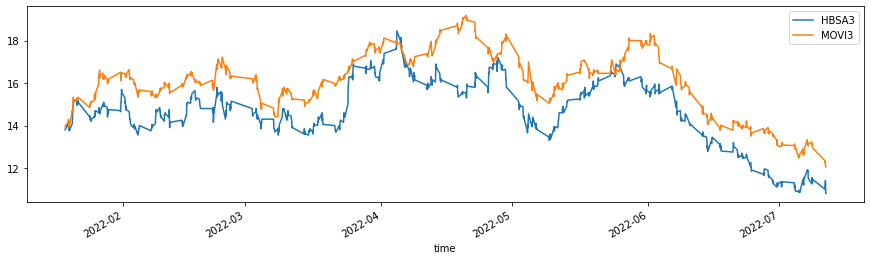

In [54]:
plot_symbols(dfc,"HBSA3","MOVI3",5,1)

In [94]:
def plot_spread(spread,ativo1,ativo2):
    
    mean = spread.mean()
    std  = spread.std()
    zscore = ( ( spread - mean )/ std )
    
    print("std:",std)

    spread.name = "spread"
    zscore.name = "zscore"
    #pd.concat([spread, zscore], axis=1).plot(figsize=(14,5))
    spread.plot(figsize=(15,4))

    plt.axhline(mean  , color='black') 
    plt.axhline(std   , color='blue' ) 
    plt.axhline(-std  , color='blue' ) 
    plt.axhline(std*2   , color='red' ) 
    plt.axhline(-std*2  , color='red' ) 
    plt.xlabel('Days')
    #plt.legend([f'Spread: {ativo2} - hedge_ratio * {ativo1}', 'zscore','average spread','std','-std'])
    plt.legend([f'Spread: {ativo2} - hedge_ratio * {ativo1}','average spread','std','-std'])
    plt.show()

    #zscore.plot(figsize=(15,4))
    #plt.axhline( zscore.mean() , color='black') 
    #plt.axhline( zscore.std()  , color='blue' ) 
    #plt.axhline(-zscore.std()  , color='blue' ) 
    #plt.axhline( zscore.std()*2  , color='red' ) 
    #plt.axhline(-zscore.std()*2  , color='red' ) 
    #plt.legend(['zscore'])
    #plt.show()


In [75]:
def analisar_long_short(dfc,ativo1,ativo2, shift1=1,shift2=1):
    spread,intercept,hedge_ratio = calc_edge_spread( dfc[ativo1],dfc[ativo2] )
    plot_symbols(dfc,ativo1,ativo2,hedge_ratio,shift2)
    plot_spread(spread,ativo1,ativo2)
    coint = is_spread_stationary(spread)
    if coint:
        print(f"{ativo1} e {ativo2} são cointegrados. hedge_ratio:{hedge_ratio}")
    else:
        print(f"{ativo1} e {ativo2} NÃO são cointegrados.")


In [104]:
def analisar_long_short2(ativo1,ativo2,ano,mes,dia,qtd,timeframe=mt5.TIMEFRAME_M15,verbose=True):
    
    #obtendo os dados na corretora...
    df1=get_all_ticker_data([ativo1,ativo2], ano,mes,dia,qtd, timeframe,verbose)
    
    #organizando para ficar com indice por data e duas colunas cada uma com o preco de fechamento de um ativo...
    df1c = df1.pivot(index='time', columns='ticker', values='close').dropna()
    if verbose: print(df1c)
    
    # emitindo a analise...
    analisar_long_short(df1c,ativo1,ativo2,shift1=1,shift2=1)



Obtendo HBSA3 1 de 2 ...
Obtendo MOVI3 2 de 2 ...
ticker               HBSA3  MOVI3
time                             
2022-06-21 12:30:00   2.54  14.11
2022-06-21 12:45:00   2.52  14.08
2022-06-21 13:00:00   2.53  14.16
2022-06-21 13:15:00   2.54  14.17
2022-06-21 13:30:00   2.53  14.18
...                    ...    ...
2022-07-13 12:30:00   2.12  11.90
2022-07-13 12:45:00   2.12  11.89
2022-07-13 13:00:00   2.11  11.89
2022-07-13 13:15:00   2.12  11.87
2022-07-13 13:30:00   2.10  11.90

[493 rows x 2 columns]


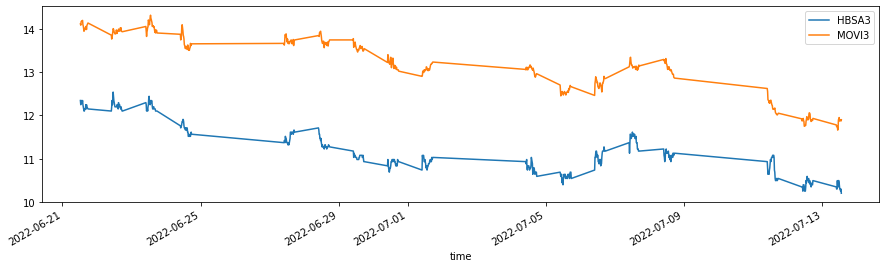

std: 0.33836960756591145


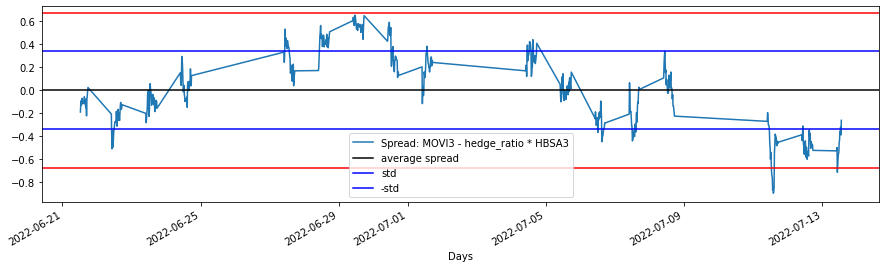

pvalue 0.284506595881 is > 0.05, assume spread is not stationary
HBSA3 e MOVI3 NÃO são cointegrados.


In [117]:
#analisar_long_short(dfc,"BOVA11","WING21",1035,1)
#analisar_long_short(dfc,"PETR3" ,"CCRO3" ,1   ,2.4)
#analisar_long_short(dfc,"WDOH21","WING21",22.3,1)
#analisar_long_short(dfc,"HAPV3","CASH3",1.9,1)
#analisar_long_short(dfc,"MGLU3","CIEL3",1,6.15)
#analisar_long_short(dfc,"PETR4","BIDI4",1.70,1)
#analisar_long_short(dfc,"CIEL3","INDG21",29000,1)
#analisar_long_short(dfc,"CESP6","VVAR3",1,2.05)     #pvalor=0.009
#analisar_long_short(dfc,"INTB3","BRKM5",1.45,1)      #pvalor=0.005
#analisar_long_short(dfc,"ABEV3","RENT3",5,1)      #pvalor=0.005
#analisar_long_short(dfc,"HBSA3","MOVI3",4.24,1)      #pvalor=0.005
analisar_long_short2("HBSA3","MOVI3",2022,7,14,500,mt5.TIMEFRAME_M15)      #pvalor=0.005
